<!-- Autogenerated by `scripts/make_examples.py` -->
<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/voxel51/fiftyone-examples/blob/master/examples/exploring_classification_hardness.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791629-6e618700-5769-11eb-857f-d176b37d2496.png" height="32" width="32">
            Try in Google Colab
        </a>
    </td>
    <td>
        <a target="_blank" href="https://nbviewer.jupyter.org/github/voxel51/fiftyone-examples/blob/master/examples/exploring_classification_hardness.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791634-6efa1d80-5769-11eb-8a4c-71d6cb53ccf0.png" height="32" width="32">
            Share via nbviewer
        </a>
    </td>
    <td>
        <a target="_blank" href="https://github.com/voxel51/fiftyone-examples/blob/master/examples/exploring_classification_hardness.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791633-6efa1d80-5769-11eb-8ee3-4b2123fe4b66.png" height="32" width="32">
            View on GitHub
        </a>
    </td>
    <td>
        <a href="https://github.com/voxel51/fiftyone-examples/raw/master/examples/exploring_classification_hardness.ipynb" download>
            <img src="https://user-images.githubusercontent.com/25985824/104792428-60f9cc00-576c-11eb-95a4-5709d803023a.png" height="32" width="32">
            Download notebook
        </a>
    </td>
</table>


# Exploring Image Hardness

Say you have a repository of data with millions of unlabeled images in it. You managed to label a subset of data and trained an image classification model on it, but it's not performing as well as you hope. **How do you decide 
which new samples to annotate and add to your training set?**

You could just randomly select new samples to annotate, but there is a better way. Hard sample mining is a tried and true method to distill a large amount of raw unlabeled data into smaller high quality labeled datasets.

*A hard sample is one that is difficult for your machine learning (ML) model to correctly predict the label of.* 

In an image classification dataset, a hard sample could be anything from a cat that looks like a dog to a blurry resolution image. If you expect your model to perform well on these hard samples, then you may need to "mine" more examples of these hard samples to add to your training dataset. Exposing your model to more hard samples during training will allow it to perform better on those types of samples later on.


Hard samples are useful for more than just training data, they are also necessary to include in your test set. If your test data is composed primarily of easy samples, then your performance will soon reach an upper bound causing progress to stagnate. Adding hard samples to a test set will give you a better idea of how models perform in harder edge cases and can provide more insight into which models are more reliable.

## Overview:

In this walkthrough, we explore how [FiftyOne’s image hardness tool](https://voxel51.com/docs/fiftyone/user_guide/brain.html) can be used to analyze and improve datasets.

We’ll cover the following concepts:

* Loading a dataset from the [FiftyOne Dataset Zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/index.html)

* Applying [FiftyOne’s sample hardness algorithm](https://voxel51.com/docs/fiftyone/user_guide/brain.html) to your dataset

* Launching the [FiftyOne App and visualizing/exploring your data](https://voxel51.com/docs/fiftyone/user_guide/app.html)

* Identifying the hardest samples in your dataset

In [ ]:
!pip install fiftyone

In [3]:
!pip install torch torchvision

## Load your data

For this example, we will be using the test split of the image classification dataset, [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). This dataset contains 10,000 test images labeled across 10 different classes. This is one of the dozens of datasets in the [FiftyOne Dataset Zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/index.html), so we can easily load it up.

In [4]:
import fiftyone as fo

In [5]:
import fiftyone.zoo as foz

In [6]:
# Download the software
!git clone --depth 1 --branch v2.1 https://github.com/huyvnphan/PyTorch_CIFAR10.git

# Download the pretrained model (90MB)
!eta gdrive download --public \
    1dGfpeFK_QG0kV-U6QDHMX2EOGXPqaNzu \
    PyTorch_CIFAR10/cifar10_models/state_dicts/resnet50.pt

fatal: destination path 'PyTorch_CIFAR10' already exists and is not an empty directory.
 100% |████|  719.8Mb/719.8Mb [9.8s elapsed, 0s remaining, 68.5Mb/s]       


In [7]:
dataset = foz.load_zoo_dataset("cifar10", split="test")

Split 'test' already downloaded
Loading 'cifar10' split 'test'
 100% |████████████████████████████████████████████████████████████| 10000/10000 [11.1s elapsed, 0s remaining, 745.2 samples/s]      
Dataset 'cifar10-test' created


**Note**: You can also [load your own dataset into FiftyOne](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html). It supports labels for many computer vision tasks including [classification, detection, segmentation, keypoints, and more](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#labels).

## Add logits
In order to calculate hardness on images in FiftyOne, you first need to use a model to compute logits for those images. You can use any model you want, but ideally, it would be one trained similar data and on the same task you will be using these new images for.

In this example, we will be using code from the [PyTorch CIFAR-10 repository](https://github.com/huyvnphan/PyTorch_CIFAR10/tree/v2.1), namely the pretrained ResNet50 classifier.

You can easily add a classification field with [logits to your samples in a FiftyOne dataset.](https://voxel51.com/docs/fiftyone/recipes/model_inference.html?highlight=logits)

In [8]:
import sys

import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader

import fiftyone.utils.torch as fout

sys.path.insert(1, "PyTorch_CIFAR10")
from cifar10_models import *


def make_cifar10_data_loader(image_paths, sample_ids, batch_size):
    mean = [0.4914, 0.4822, 0.4465]
    std = [0.2023, 0.1994, 0.2010]
    transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean, std),
        ]
    )
    dataset = fout.TorchImageDataset(
        image_paths, sample_ids=sample_ids, transform=transforms
    )
    return DataLoader(dataset, batch_size=batch_size, num_workers=4)


def predict(model, imgs):
    logits = model(imgs).detach().cpu().numpy()
    predictions = np.argmax(logits, axis=1)
    odds = np.exp(logits)
    confidences = np.max(odds, axis=1) / np.sum(odds, axis=1)
    return predictions, confidences, logits

In [9]:
#
# Load a model
#
# Model performance numbers are available at:
#   https://github.com/huyvnphan/PyTorch_CIFAR10
#

model = resnet50(pretrained=True)
model_name = "resnet50"

In [12]:
num_samples = 1000

view = dataset.take(num_samples)

In [14]:
image_paths, sample_ids = zip(
    *[(s.filepath, s.id) for s in view.iter_samples()]
)

In [16]:
num_samples = 1000
batch_size = 20

classes = dataset.info["classes"]

data_loader = make_cifar10_data_loader(image_paths, sample_ids, batch_size)

#
# Perform prediction and store results in dataset
#

for imgs, sample_ids in data_loader:
    predictions, confidences, logits_ = predict(model, imgs)

    # Add predictions to your FiftyOne dataset
    for sample_id, prediction, confidence, logits in zip(sample_ids, predictions, confidences, logits_):
        sample = dataset[sample_id]
        sample.tags.append("processed")
        sample[model_name] = fo.Classification(
            label=classes[prediction], logits=logits, confidence=confidence
        )
        sample.save()

In [17]:
processed_view = dataset.match_tags(["processed"])

In [18]:
processed_view

Dataset:        cifar10-test
Media type:     image
Num samples:    1000
Tags:           ['processed', 'test']
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    resnet50:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
View stages:
    1. MatchTags(tag=['processed'])


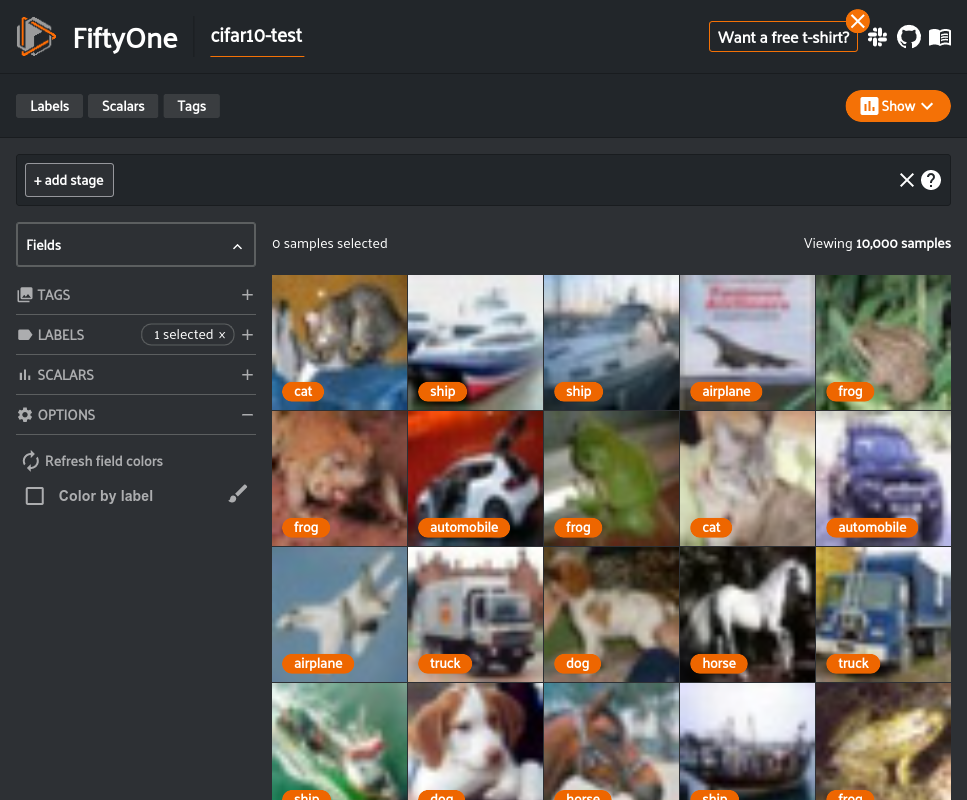


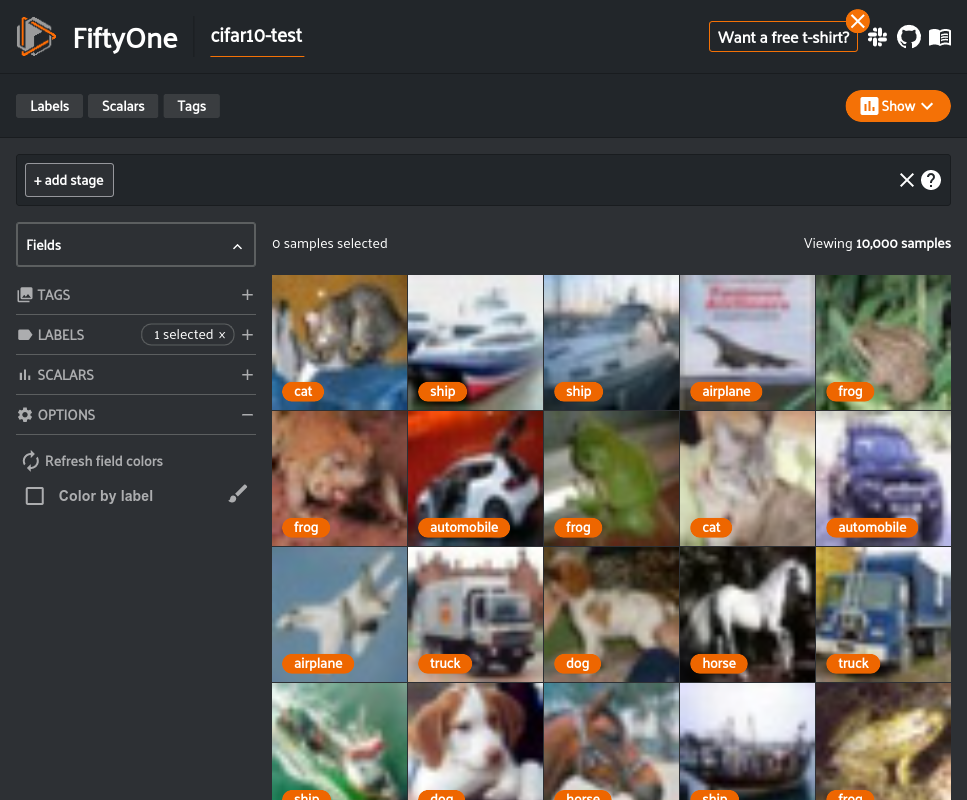

In [21]:
session = fo.launch_app(view=processed_view)

## Compute hardness

[The FiftyOne Brain](https://voxel51.com/docs/fiftyone/user_guide/brain.html) contains various useful methods that can provide insights into your data. You can compute the uniqueness of your data, the hardest samples, as well as annotation mistakes.

Once you have loaded your dataset and added logits to your samples, you calculate hardness in one line of code. The algorithm used to compute hardness is closed-source, but is based on the uncertainty of the prediction model about what label to assign.

In [20]:
import fiftyone.brain as fob

In [22]:
fob.compute_hardness(processed_view, label_field=model_name)

Computing hardness...
 100% |██████████████████████████████████████████████████████████████| 1000/1000 [2.4s elapsed, 0s remaining, 411.0 samples/s]      
Hardness computation complete



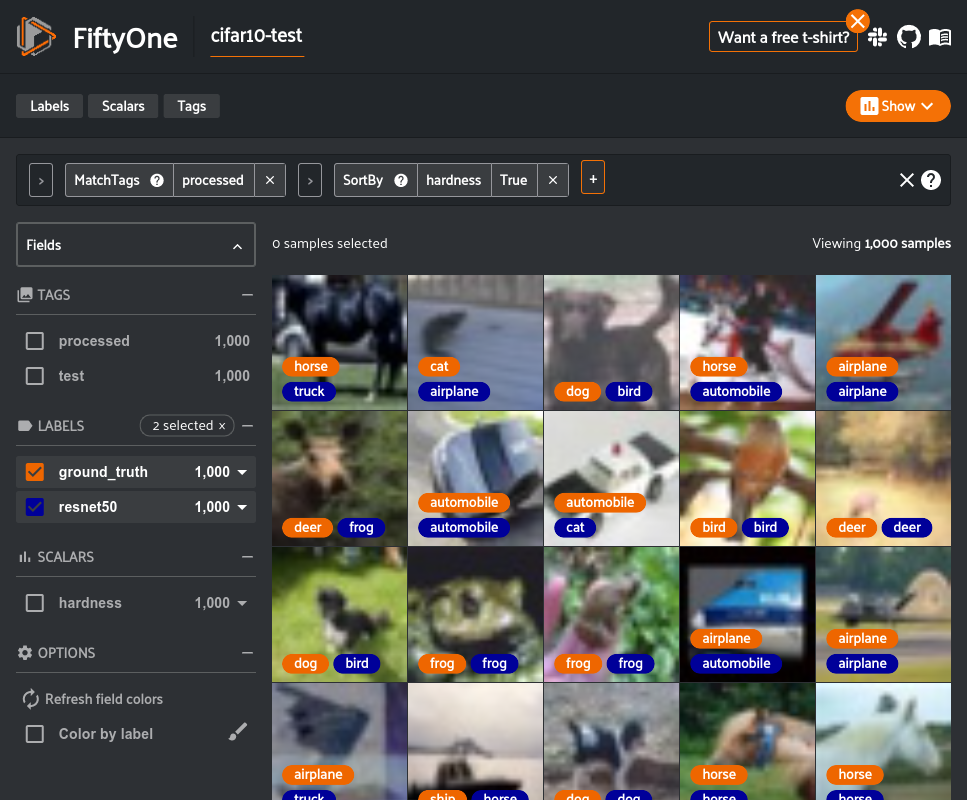


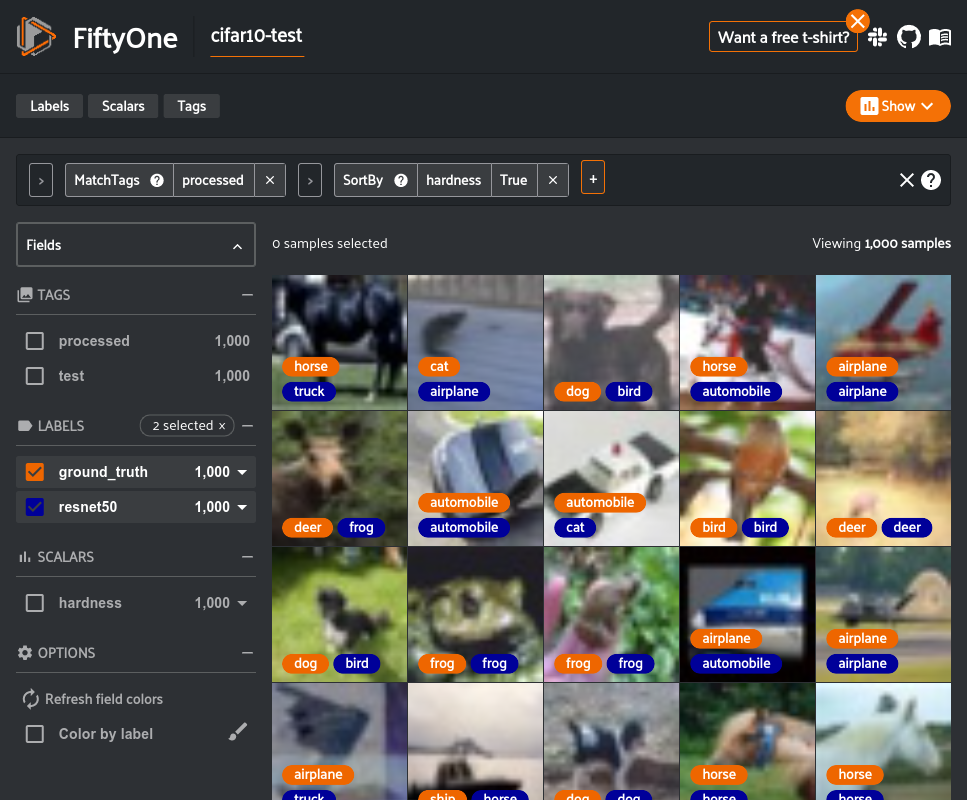

In [23]:
session.view = processed_view.sort_by("hardness")

## Explore and identify the hardest samples

You can visualize your dataset and explore the samples with the highest and lowest hardness scores with the FiftyOne App.

In [26]:
from fiftyone import ViewField as F

We can write some queries to dig a bit deeper into these hardness calculations and how they relate to other aspects of the data.

For example, we can see the distribution of hardness correct and incorrect predictions of the model separately.

In [116]:
# Correct Preds
correct_view = processed_view.match(F("ground_truth.label") == F(model_name+".label"))

# Incorrect Preds
incorrect_view = processed_view.match(F("ground_truth.label") != F(model_name+".label"))

print(correct_view)
print(incorrect_view)

Dataset:        cifar10-test
Media type:     image
Num samples:    816
Tags:           ['processed', 'test']
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    resnet50:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    hardness:     fiftyone.core.fields.FloatField
View stages:
    1. MatchTags(tag=['processed'])
    2. Match(filter={'$expr': {'$eq': [...]}})
Dataset:        cifar10-test
Media type:     image
Num samples:    184
Tags:           ['processed', 'test']
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedD

In [121]:
print("Incorrect predictions avg hardness: %f" % (incorrect_view.sum("hardness")/incorrect_view.count()))
print("Correct predictions avg hardness: %f" % (correct_view.sum("hardness")/correct_view.count()))
print("Total avg hardness: %f" % (processed_view.sum("hardness")/processed_view.count()))

Incorrect predictions avg hardness: 0.821605
Correct predictions avg hardness: 0.542321
Total avg hardness: 0.593709


In [113]:
session.view = correct_view


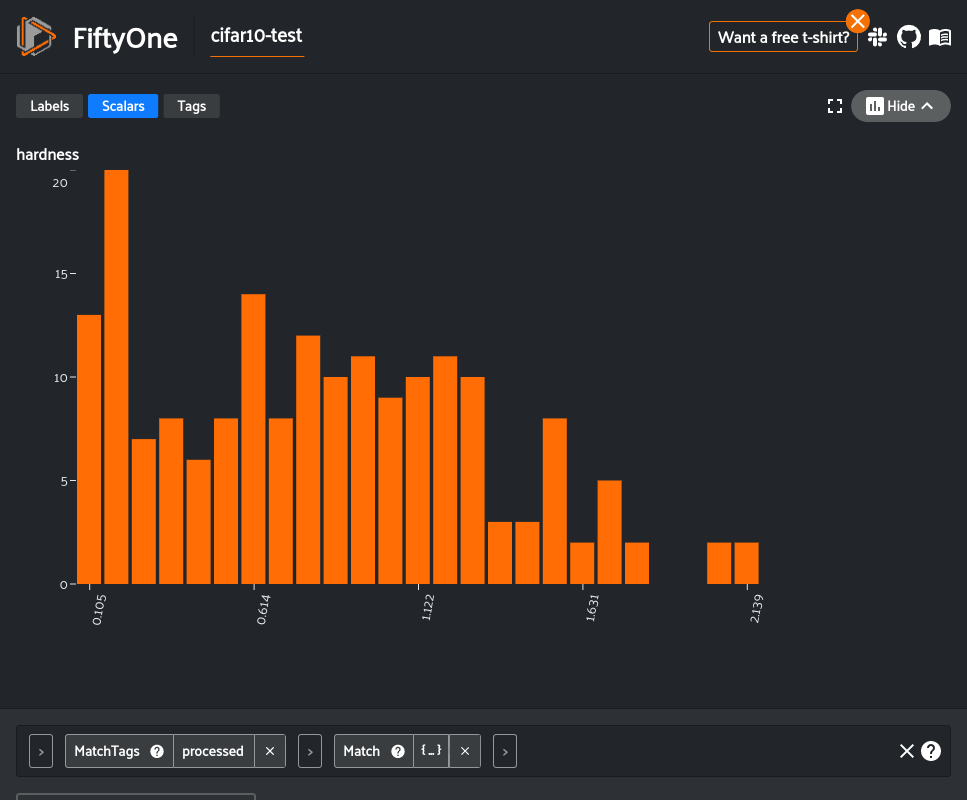


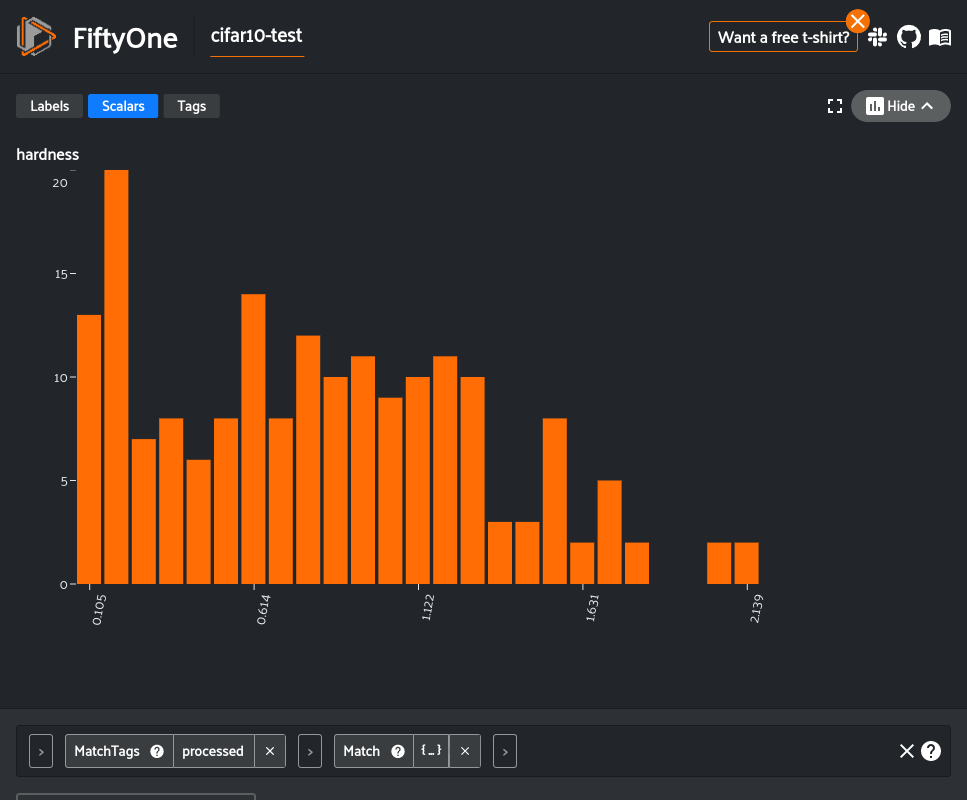

In [112]:
session.view = incorrect_view

In [115]:
cls_hardness = []

for label in processed_view.distinct("ground_truth.label"):
    label_view = processed_view.match(F("ground_truth.label")==label)
    avg_hardness = label_view.sum("hardness")/label_view.count()
    cls_hardness.append([avg_hardness, label])

for avg_hardness, label in sorted(cls_hardness):
    print("Average hardness %s: %f" % (label, avg_hardness))

Average hardness automobile: 0.522104
Average hardness ship: 0.545399
Average hardness truck: 0.561360
Average hardness deer: 0.572543
Average hardness bird: 0.587939
Average hardness horse: 0.589780
Average hardness cat: 0.620570
Average hardness frog: 0.621375
Average hardness airplane: 0.643586
Average hardness dog: 0.669269


## What's next?

Once you've identified the hardest samples you have available, it's time to update your dataset. You can select the X samples with the highest hardness value to send off to get annotated and added to your train or test set.

Retraining your model on this new data should now allow it to perform better on harder edge cases. Additionally, adding these samples to your test set will let you be more confident in the ability of your model to perform well on new unseen data if it performs well on your test set.

Now it's time to keep improving your dataset by [fixing annotation mistakes](https://voxel51.com/docs/fiftyone/recipes/detection_mistakenness.html) and [adding more unqiue samples](https://voxel51.com/docs/fiftyone/tutorials/uniqueness.html).